In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# defining dataset path
train_dataset_path = '/content/gdrive/MyDrive/image_dataset_final/data_sorted'
test_dataset_path = '/content/gdrive/MyDrive/image_dataset_final/test_sorted'
os.listdir(test_dataset_path)

['drawingroom', 'officeroom', 'bedroom']

In [4]:
# image processing

mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2038]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)),
])

In [5]:
# importing dataset
train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform = test_transforms)

In [6]:
def show_transforms_images(dataset):
  loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
  batch = next(iter(loader))
  images, labels = batch
  
  grid = torchvision.utils.make_grid(images, nrow = 3)
  plt.figure(figsize = (5, 11))
  plt.imshow(np.transpose(grid, (1, 2, 0)))
  print('labels', labels)

labels tensor([1, 0, 1, 2, 0, 0])


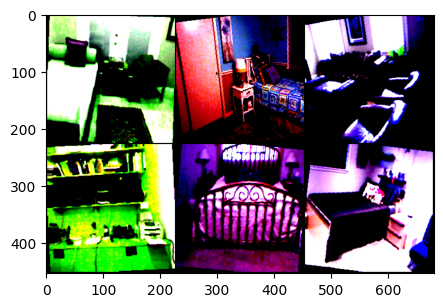

In [7]:
show_transforms_images(train_dataset)

In [8]:
# importing images to dataloader

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [9]:
def set_device():
  if torch.cuda.is_available():
    dev = 'cuda'
  else:
    dev = 'cpu'
  print("Device type is ", dev)
  return torch.device(dev)

In [17]:
class VGNN(nn.Module):
    def __init__(self, num_classes):
        super(VGNN, self).__init__()
        
        # Load a pre-trained ResNet-18 model
        resnet = models.resnet18(pretrained=False)
        
        # Remove the last layer of the ResNet-18 model
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        
        # Construct the graph convolutional layers
        self.gc1 = nn.Conv2d(512, 256, kernel_size=1)
        self.gc2 = nn.Conv2d(256, 128, kernel_size=1)
        self.gc3 = nn.Conv2d(128, 64, kernel_size=1)
        self.gc4 = nn.Conv2d(64, 13, kernel_size=1)  # Output size of 13
        
        # Construct the fully connected layer
        self.fc = nn.Linear(13, num_classes)
        
    def forward(self, x):
        # Extract features from the ResNet-18 model
        features = self.resnet(x)
        
        # Compute the pairwise similarities between features
        similarities = torch.matmul(features, features.permute(0,2,3,1))
        
        # Construct the adjacency matrix from the pairwise similarities
        adj_matrix = F.softmax(similarities, dim=-1)
        
        # Pass the adjacency matrix through the graph convolutional layers
        x = F.relu(self.gc1(adj_matrix))
        x = F.relu(self.gc2(x))
        x = F.relu(self.gc3(x))
        x = F.relu(self.gc4(x))
        
        # Compute the global features by taking the average of the graph features
        global_features = torch.mean(x, dim=[2, 3])
        
        # Pass the global features through the fully connected layer
        logits = self.fc(global_features)
        
        return logits

In [ ]:
# this function will be called for traiming purpose
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
  device = set_device()
  best_acc = 0
  for epoch in range(n_epochs):
    print('Epoch number ', (epoch + 1))
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    
    for data in train_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      optimizer.zero_grad()
      outputs = model(images)
      _ , predicted = torch.max(outputs.data, 1)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      running_correct += (labels == predicted).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100.0 * running_correct / total

    print(" Training Dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss %0.3f" % (running_correct, total, epoch_accuracy, epoch_loss))

    test_dataset_acc = evaluate_model_on_test_set(model, test_loader)
    if( test_dataset_acc > best_acc ) :
      best_acc = test_dataset_acc
      save_checkpoint(model, epoch, optimizer, best_acc)
  print('Finished')
  return model

In [ ]:
# this function evaluates accuracy for test set
def evaluate_model_on_test_set(model, test_loader):
  model.eval()
  predicted_correctly_on_epoch = 0
  total = 0
  device = set_device()

  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      outputs = model(images)

      _, predicted = torch.max(outputs.data, 1)
      predicted_correctly_on_epoch += (labels == predicted).sum().item()

  epoch_acc = predicted_correctly_on_epoch * 100.0 / total
  print('Testing dataset. Got %d out of %d images correctly (%0.3f%%)' % 
        (predicted_correctly_on_epoch, total, epoch_acc))
  return epoch_acc

In [ ]:
def save_checkpoint(model, epoch, optimizer, best_acc):
  state = {
      'epoch' : epoch + 1,
      'model' : model.state_dict(),
      'best_accuracy' : best_acc,
      'optimizer' : optimizer.state_dict()
  }
  torch.save(state, '/content/gdrive/MyDrive/image_dataset_final/model_best_checkpoint.pth.tar')

In [25]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

device = set_device()
loss_fn = nn.CrossEntropyLoss()
model = VGNN(num_classes=3)

# using stochasting gradient descent optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.003)

Device type is  cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# training images
trained_model = train_nn(model, train_loader, test_loader, loss_fn, optimizer, 50)

Device type is  cpu
Epoch number  1
 Training Dataset. Got 84 out of 282 images correctly (29.787%). Epoch loss 1.100
Device type is  cpu
Testing dataset. Got 6 out of 18 images correctly (33.333%)
Epoch number  2
 Training Dataset. Got 104 out of 282 images correctly (36.879%). Epoch loss 1.098
Device type is  cpu
Testing dataset. Got 6 out of 18 images correctly (33.333%)
Epoch number  3
 Training Dataset. Got 104 out of 282 images correctly (36.879%). Epoch loss 1.097
Device type is  cpu
Testing dataset. Got 6 out of 18 images correctly (33.333%)
Epoch number  4
 Training Dataset. Got 104 out of 282 images correctly (36.879%). Epoch loss 1.095
Device type is  cpu
Testing dataset. Got 6 out of 18 images correctly (33.333%)
Epoch number  5
 Training Dataset. Got 104 out of 282 images correctly (36.879%). Epoch loss 1.095
Device type is  cpu
Testing dataset. Got 6 out of 18 images correctly (33.333%)
Epoch number  6
 Training Dataset. Got 104 out of 282 images correctly (36.879%). Epoc

In [13]:
# loading saved checkpoint
checkpoint = torch.load('/content/gdrive/MyDrive/image_dataset_final/model_best_checkpoint.pth.tar')
checkpoint['epoch']

1

In [26]:
# saving the best model
# resnet18_model = models.resnet18()
VGNN_model = model
num_ftrs = VGNN_model.fc.in_features
number_of_classes = 3
VGNN_model.fc = nn.Linear(num_ftrs, number_of_classes)
VGNN_model.load_state_dict(checkpoint['model'])

torch.save(VGNN_model, '/content/gdrive/MyDrive/image_dataset_final/best_model.pth')

In [27]:
best_model = torch.load('/content/gdrive/MyDrive/image_dataset_final/best_model.pth')

In [28]:
import PIL.Image as Image

classes = ['bedroom', 'drawingroom', 'officeroom']

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)),
])

In [29]:
def classify(model, image_transforms, image_path, classes):
  model = model.eval()
  image = Image.open(image_path)
  image = image_transforms(image).float()
  image = image.unsqueeze(0)

  output = model(image)
  _, predicted = torch.max(output.data, 1)
  print(classes[predicted.item()])

In [30]:
image_path = '/content/gdrive/MyDrive/image_dataset_final/test_sorted/bedroom/image196.png'
classify(best_model, image_transforms, image_path, classes)

bedroom
